<a href="https://colab.research.google.com/github/AndreYang333/ExplainableAI/blob/main/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5
## Minjie Yang(my189)

## LIME for RESNET(model)

### Prepare model and libraries

In [30]:
!pip install lime torch torchvision tqdm

In [31]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pre-trained ResNet34 model
model = models.resnet34(pretrained=True).to(device)
model.eval()

# Define the image transformation to match the ResNet34 input size
preprocess = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Load class names of imagenet

In [32]:
# Load class names
class_names_path = "/content/imagenet_classes.txt"

# check whether it is good
with open(class_names_path, "r") as f:
    class_names = [line.strip() for line in f.readlines()]

print(class_names[:5])


['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']


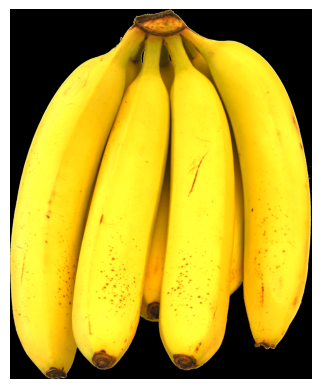

In [34]:
# sample of banana
img_path = "/content/Banana.png"
img = Image.open(img_path).convert('RGB')
plt.imshow(img)
plt.axis('off')
plt.show()
img_tensor = preprocess(img).unsqueeze(0).to(device)


In [35]:

# Predict
with torch.no_grad():
    output = model(img_tensor)
_, predicted_class = output.max(1)
predicted_label = class_names[predicted_class.item()]
print(f"Predicted class: {predicted_label}")

Predicted class: banana


In [36]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt


def classifier_fn(images):
    images = torch.from_numpy(images).permute(0, 3, 1, 2).float().to(device)
    with torch.no_grad():
        outputs = model(images).cpu().detach().numpy()
    return outputs
# Initialize LIME explainer for images
explainer = lime_image.LimeImageExplainer()

# Explain the model's predictions for the image
explanation = explainer.explain_instance(np.array(img),
                      classifier_fn=classifier_fn,
                      top_labels=5,
                      hide_color=0,
                      num_samples=500)


  0%|          | 0/500 [00:00<?, ?it/s]

LIME top labels (indexes): [579, 645, 497, 875, 644]
LIME top labels (names): ['grand piano', 'maypole', 'church', 'trombone', 'matchstick']
Predicted class 954 not in LIME top labels, using top label: grand piano


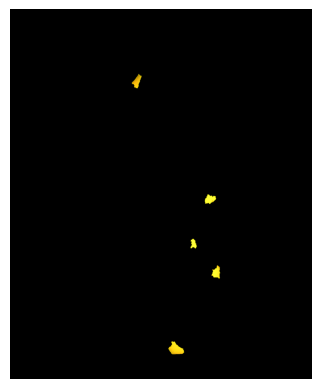

In [38]:
print(f"LIME top labels (indexes): {explanation.top_labels}")

lime_top_labels_names = [class_names[i] for i in explanation.top_labels]
print(f"LIME top labels (names): {lime_top_labels_names}")

# 检查 predicted_class 是否在 LIME 解释结果中
if predicted_class.item() in explanation.top_labels:
    # 获取解释结果
    temp, mask = explanation.get_image_and_mask(predicted_class.item(), positive_only=True, num_features=5, hide_rest=False)
    predicted_label_name = class_names[predicted_class.item()]  # 获取类别名称
    print(f"Explaining predicted class: {predicted_label_name}")
else:
    # 使用 LIME 排名最高的类别进行解释
    top_label = explanation.top_labels[0]
    top_label_name = class_names[top_label]  # 获取 LIME 排名最高的类别名称
    print(f"Predicted class {predicted_class.item()} not in LIME top labels, using top label: {top_label_name}")
    temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=5, hide_rest=True)

# 显示 LIME 解释结果
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.show()


## Discussion

**LIME was chosen** for its ability to explain any machine learning model without requiring access to internal workings, providing local, human-understandable explanations for individual predictions. It is simple to implement and supports various data types (images, text, tabular).

### Strengths:
- **Model-Agnostic**: Works with any model using prediction outputs.
- **Local Explanations**: Focuses on specific samples, making it ideal for varying predictions.
- **Intuitive Visualization**: Provides easy-to-understand visual explanations.
- **Ease of Use**: A well-supported library that integrates easily with various models.

### Limitations:
1. **Approximation, Not Exact**: LIME uses a simple surrogate model to approximate the behavior of the original model, which may not fully capture its complexity.
2. **Defining the Neighborhood**: It can be challenging to define an appropriate "neighborhood" around the instance being explained, which can lead to misleading interpretations.
3. **Instability of Explanations**: LIME’s explanations can vary across runs or experiments due to randomness in the perturbation process.
4. **Bias and Manipulation**: LIME can be fooled into hiding biases, and explanations can be manipulated by altering the perturbations or the surrogate model.
5. **Computational Cost**: Generating many perturbed samples and evaluating them with the black-box model is resource-intensive, particularly for large models.
6. **Limited Global Insight**: LIME provides only local explanations, which are useful for understanding individual predictions but do not offer insights into the model's global behavior.

### Improvements:
- **Stability**: Techniques such as smoothing or averaging over multiple LIME runs can reduce the variability and increase the consistency of explanations.
- **Integration with Global Techniques**: Combining LIME with global explanation methods like SHAP can offer a more comprehensive understanding of model behavior.
- **Better Perturbations**: More realistic perturbation methods, especially for text and images, could enhance the accuracy of the explanations. For example, semantic masking in images can yield better local approximations.

